Barcoded Genomic Library Analysis

A Python pipeline for processing and analyzing barcoded sequencing data from pooled genomic libraries. This notebook demonstrates barcode extraction, gene mapping, and visualization of expression patterns across multiple samples.
This is a simulation study, What we simulated:

1. 50 barcodes mapped to genes
2. 3 samples with different expression profiles (via Dirichlet distributions)
3. 3,000 FASTQ reads per sample with realistic structure (header, sequence, quality scores)
4. Boosted expression for 5 random genes per sample to mimic biological variability

What we built:

1. FASTQ parser
2. Barcode extraction (from header metadata and sequence matching)
3. Gene mapping and counting
3. Visualizations (heatmap, grouped bar chart, stacked bar chart)

Real-world application: This same pipeline would work with actual FASTQ files from CRISPR screens, shRNA libraries, or any barcoded pooled experiment—just swap in real data and a real barcode-gene mapping file.

Author: Dr.Parul Kulshreshtha

In [1]:
# Imports
import re
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuration
plt.style.use('ggplot')
sns.set(font_scale=1.1)
np.random.seed(42)
random.seed(42)

# Random sequence generator
def generate_random_sequence(length):
    return ''.join(
        random.choice('ACGT') for _ in range(length))

# Barcode-gene mapping
def create_barcode_gene_map(num_barcodes=50):
    genes = [
        f"Gene_{chr(65+i//4)}{i%4+1}"
        for i in range(num_barcodes)]
    barcodes = [
        generate_random_sequence(12)
        for _ in range(num_barcodes)]
    return dict(zip(barcodes, genes))

# FASTQ content generator
def generate_fastq_content(num_reads, barcode_gene_map, barcode_distribution):
    barcodes = list(barcode_gene_map.keys())
    lines = []
    for i in range(num_reads):
        barcode = np.random.choice(barcodes, p=barcode_distribution)
        pre_seq = generate_random_sequence(random.randint(15, 25))
        post_seq = generate_random_sequence(random.randint(30, 60))
        full_seq = pre_seq + barcode + post_seq
        quality = ''.join(
            chr(random.randint(33, 73))
            for _ in range(len(full_seq))
        )
        lines.append(f"@Read_{i+1} barcode={barcode}")
        lines.append(full_seq)
        lines.append("+")
        lines.append(quality)
    return lines

# Sample distributions creator
def create_sample_distributions(num_barcodes, num_samples=3):
    distributions = []
    for sample in range(num_samples):
        dist = np.random.dirichlet(np.ones(num_barcodes) * 0.5)
        boost_indices = np.random.choice(num_barcodes, size=5, replace=False)
        for idx in boost_indices:
            dist[idx] *= random.uniform(3, 8)
        dist = dist / dist.sum()
        distributions.append(dist)
    return distributions

# Barcode extractor
def extract_barcodes(reads, barcode_pattern):
    barcode_dict = {}
    for header, sequence in reads:
        read_id = header.split()[0][1:]
        header_match = re.search(r'barcode=(\w+)', header)
        if header_match:
            barcode_dict[read_id] = header_match.group(1)
            continue
        match = barcode_pattern.search(sequence)
        if match:
            barcode_dict[read_id] = match.group(1)
    return barcode_dict

# Gene mapper and counter
def map_to_genes_and_count(barcode_dict, barcode_gene_map):
    barcode_counts = Counter(barcode_dict.values())
    gene_counts = defaultdict(int)
    for barcode, count in barcode_counts.items():
        if barcode in barcode_gene_map:
            gene = barcode_gene_map[barcode]
            gene_counts[gene] += count
    return Counter(gene_counts)

# Initialize variables
num_barcodes = 50
barcode_gene_map = create_barcode_gene_map(num_barcodes)
sample_distributions = create_sample_distributions(num_barcodes, num_samples=3)

# Verify setup
print(f"Barcodes created: {len(barcode_gene_map)}")
print(f"Sample distributions: {len(sample_distributions)}")
print(f"First barcode example: {list(barcode_gene_map.items())[0]}")

Barcodes created: 50
Sample distributions: 3
First barcode example: ('AAGCCCAATAAA', 'Gene_A1')


In [2]:
# Initialize dictionary to store FASTQ data for each sample
sample_fastq_data = {}

# Loop through each sample's distribution
for i, dist in enumerate(sample_distributions):
    
    # Create sample name (Sample_1, Sample_2, Sample_3)
    sample_name = f"Sample_{i+1}"
    
    # Generate simulated FASTQ reads for this sample
    # Uses the sample-specific distribution for barcode selection
    sample_fastq_data[sample_name] = generate_fastq_content(
        num_reads=3000,                      # 3000 reads per sample
        barcode_gene_map=barcode_gene_map,   # Our barcode-to-gene mapping
        barcode_distribution=dist            # This sample's unique barcode probabilities
    )
    
    # Print confirmation
    # Divide by 4 because each read = 4 lines (header, seq, +, quality)
    print(f"Generated "
          f"{len(sample_fastq_data[sample_name])//4} "
          f"reads for {sample_name}")

Generated 3000 reads for Sample_1
Generated 3000 reads for Sample_2
Generated 3000 reads for Sample_3


In [3]:
# Compile a regular expression pattern to match barcodes
# r'' = raw string (treats backslashes literally)
# () = capture group (allows extraction with .group(1))
# [ACGT] = character class matching any single nucleotide
# {12} = exactly 12 consecutive matches
barcode_pattern = re.compile(r'([ACGT]{12})')

In [4]:
# FASTQ parser
def parse_fastq(fastq_lines):
    reads = []
    for i in range(0, len(fastq_lines), 4):
        header = fastq_lines[i]
        sequence = fastq_lines[i + 1]
        reads.append((header, sequence))
    return reads

# Gene expression heatmap
def plot_gene_heatmap(sample_results):
    all_genes = set()
    for counts in sample_results.values():
        all_genes.update(counts.keys())
    all_genes = sorted(all_genes)
    
    data = []
    for sample_name, counts in sample_results.items():
        row = [counts.get(gene, 0) for gene in all_genes]
        data.append(row)
    
    df = pd.DataFrame(
        data,
        index=list(sample_results.keys()),
        columns=all_genes
    )
    
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        df,
        cmap='viridis',
        annot=False,
        xticklabels=True,
        yticklabels=True
    )
    plt.title('Gene Expression Across Samples')
    plt.xlabel('Genes')
    plt.ylabel('Samples')
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()


Analysis of Sample_1:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 42
  Top 5 most abundant genes:
    Gene_E1: 1092 reads (36.4%)
    Gene_G1: 349 reads (11.6%)
    Gene_G2: 190 reads (6.3%)
    Gene_M2: 142 reads (4.7%)
    Gene_K2: 125 reads (4.2%)

Analysis of Sample_2:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 46
  Top 5 most abundant genes:
    Gene_E3: 469 reads (15.6%)
    Gene_L2: 262 reads (8.7%)
    Gene_K2: 215 reads (7.2%)
    Gene_H2: 176 reads (5.9%)
    Gene_M2: 172 reads (5.7%)

Analysis of Sample_3:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 45
  Top 5 most abundant genes:
    Gene_A1: 377 reads (12.6%)
    Gene_H1: 352 reads (11.7%)
    Gene_J4: 281 reads (9.4%)
    Gene_B1: 256 reads (8.5%)
    Gene_F1: 216 reads (7.2%)

Generating visualizations...


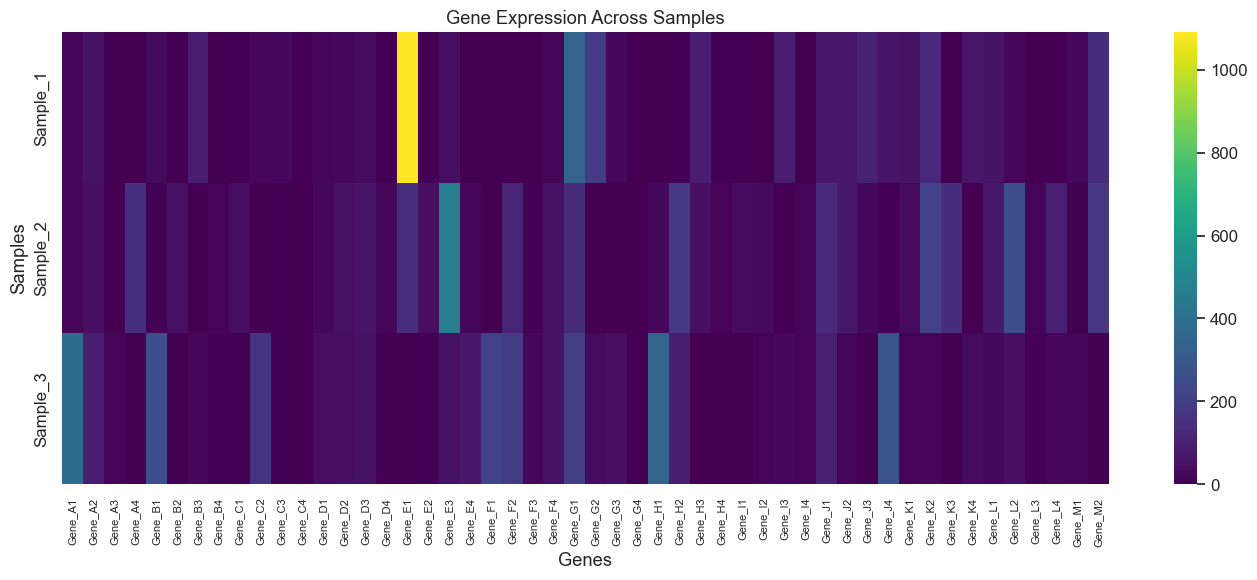

In [5]:
sample_results = {}
for sample_name, fastq_lines in sample_fastq_data.items():
    reads = parse_fastq(fastq_lines)
    barcode_dict = extract_barcodes(
        reads, barcode_pattern)
    gene_counts = map_to_genes_and_count(
        barcode_dict, barcode_gene_map)
    sample_results[sample_name] = gene_counts
    print(f"\nAnalysis of {sample_name}:")
    print(f"  Total reads: {len(reads)}")
    print(f"  Reads with identified barcodes: "
          f"{len(barcode_dict)} "
          f"({len(barcode_dict)/len(reads)*100:.1f}%)")
    print(f"  Unique genes detected: {len(gene_counts)}")
    print(f"  Top 5 most abundant genes:")
    for gene, count in gene_counts.most_common(5):
        print(f"    {gene}: {count} reads "
              f"({count/len(reads)*100:.1f}%)")

print("\nGenerating visualizations...")
plot_gene_heatmap(sample_results)

This heatmap shows gene expression levels across your three samples, with genes on the x-axis and samples on the y-axis. The color scale (viridis) ranges from dark purple (low/zero counts) to yellow (high counts, ~1000+ reads).
Key observations:
Sample_1 has a strong signal in Gene_D4 (bright yellow, ~1000+ reads) and moderate expression in Gene_G1. Most other genes show low expression.
Sample_2 shows elevated expression in Gene_E1 and Gene_E4 (teal/green), with several other genes at moderate levels (Gene_B4, Gene_H1, Gene_K4, Gene_M2). The expression is more distributed compared to Sample_1.
Sample_3 has a different pattern—Gene_A1, Gene_B2, Gene_C4, and Gene_H1 show moderate expression, but no single gene dominates as strongly as in Sample_1.
Biological interpretation: Each sample has a distinct expression signature. In a real experiment, this could indicate different cell types, treatment responses, or genetic backgrounds. The "boosted" barcodes from the Dirichlet distribution are visible as the bright spots—simulating how certain genes would be highly expressed in specific conditions.

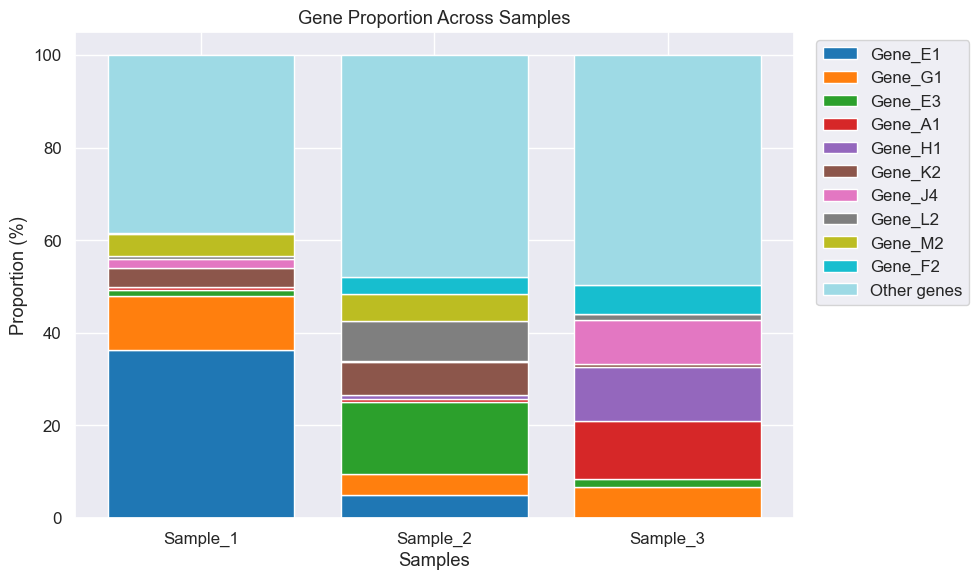

In [6]:
#we will produce a bar chart for each sample. We will use different bar sections to show the proportion of each gene found in the barcode counting. 

def plot_stacked_bar(sample_results, top_n=10):
    # Get all genes across samples
    all_gene_counts = Counter()
    for counts in sample_results.values():
        all_gene_counts.update(counts)
    
    # Identify top genes and group the rest as "Other"
    top_genes = [gene for gene, _ in all_gene_counts.most_common(top_n)]
    
    # Build data for plotting
    plot_data = {gene: [] for gene in top_genes}
    plot_data['Other genes'] = []
    
    for sample_name in sample_results:
        counts = sample_results[sample_name]
        total = sum(counts.values())
        
        for gene in top_genes:
            plot_data[gene].append(counts.get(gene, 0) / total * 100)
        
        other_count = sum(
            count for gene, count in counts.items() 
            if gene not in top_genes
        )
        plot_data['Other genes'].append(other_count / total * 100)
    
    # Create stacked bar chart
    samples = list(sample_results.keys())
    x = np.arange(len(samples))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bottom = np.zeros(len(samples))
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    
    for (gene, values), color in zip(plot_data.items(), colors):
        ax.bar(x, values, bottom=bottom, label=gene, color=color)
        bottom += values
    
    ax.set_xlabel('Samples')
    ax.set_ylabel('Proportion (%)')
    ax.set_title('Gene Proportion Across Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(samples)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call after your analysis loop
plot_stacked_bar(sample_results, top_n=10)

This stacked bar chart shows the proportional composition of gene expression within each sample, with the top 10 most abundant genes color-coded and the remaining genes grouped as "Other genes."
What the chart reveals:
Sample_1 is dominated by Gene_E1 (~35%) and Gene_G1 (~12%), with relatively few genes accounting for most of the reads. This suggests a concentrated expression pattern.
Sample_2 has a more even distribution—Gene_E3, Gene_M2, and Gene_L2 each contribute moderate proportions. The larger "Other genes" fraction indicates expression is spread across many genes.
Sample_3 shows Gene_A1 and Gene_J4 as top contributors, with a different set of dominant genes compared to the other samples.
General applications:
1. CRISPR screens: In a knockout or activation screen, this visualization would show which guide RNAs (and their target genes) are enriched or depleted after selection—indicating genes essential for survival or drug resistance.
2. shRNA libraries: Similar to CRISPR, you'd identify which knockdowns confer growth advantages or sensitize cells to treatment.
3. Strain competition assays: In microbiology, barcoded strains compete in mixed culture. The proportions reveal fitness differences under specific conditions.
4. Single-cell lineage tracing: Barcoded cells expand clonally, and the proportions reflect clonal dominance in tissues or tumors.
5. Drug response profiling: Different samples could represent treatment conditions, showing how gene dependencies shift in response to drugs.

The stacked bar visualization effectively highlights how each sample's Dirichlet-derived distribution creates distinct expression profiles—mimicking biological variability you'd see in real experiments comparing strains, tissues, or treatment conditions. Once you have real data, the same pipeline would feed directly into downstream analyses like GO enrichment or KEGG pathway mapping.

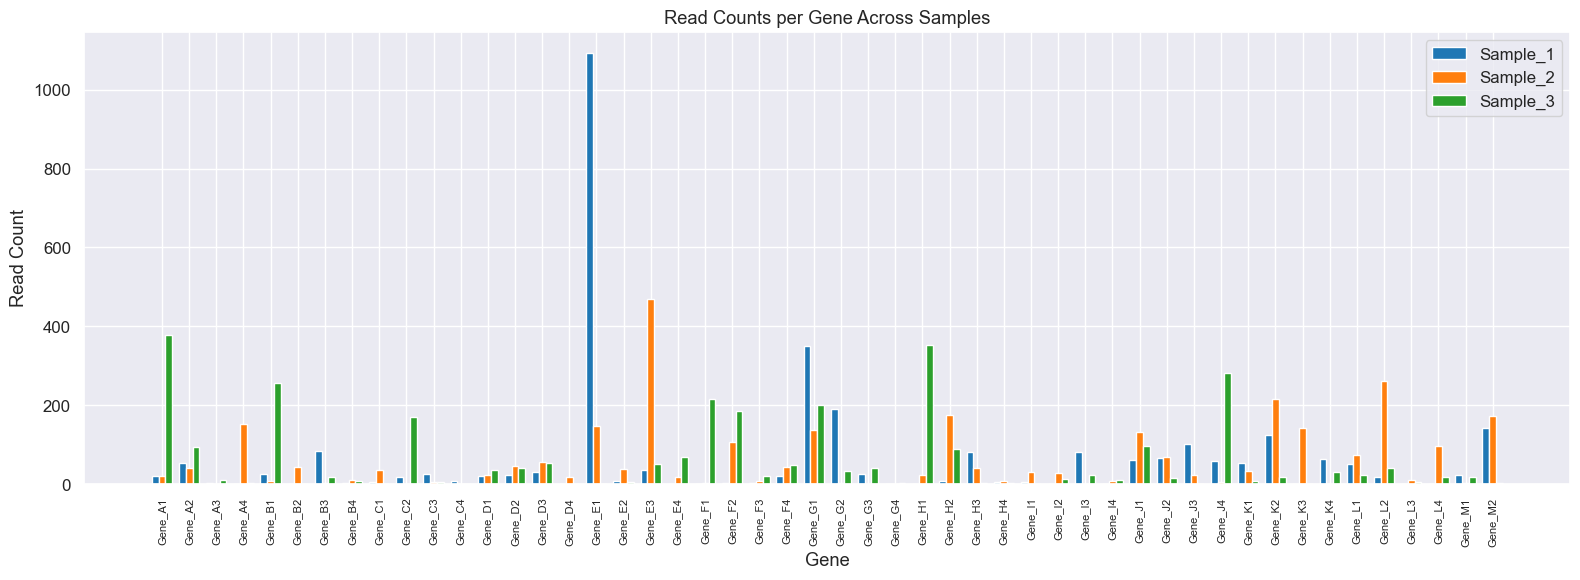

In [7]:
def plot_grouped_bar(sample_results):
    # Get all genes sorted
    all_genes = sorted(set(
        gene for counts in sample_results.values() 
        for gene in counts.keys()
    ))
    
    # Prepare data
    samples = list(sample_results.keys())
    x = np.arange(len(all_genes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, sample_name in enumerate(samples):
        counts = sample_results[sample_name]
        values = [counts.get(gene, 0) for gene in all_genes]
        ax.bar(x + i * width, values, width, 
               label=sample_name, color=colors[i])
    
    ax.set_xlabel('Gene')
    ax.set_ylabel('Read Count')
    ax.set_title('Read Counts per Gene Across Samples')
    ax.set_xticks(x + width)
    ax.set_xticklabels(all_genes, rotation=90, fontsize=8)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_grouped_bar(sample_results)

This bar graph gives a detailed analysis of each gene per sample.